5/10/15/20/25/30 일 기준 질문을 30개씩 샘플링 X 10번 반복  
각 버전 별로 난이도 비율 계산하여 chow test 수행 
일자별로 계산하여 시각화

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lib.stats.stats as st
import lib.annotation.Result_Prep as rp
import config.config as conf


In [3]:
fig_path = './fig/'
path = f'../LLM/result/'
file_list = os.listdir(path)

In [4]:
r_p = rp.Result_Prep()

In [5]:
sample1_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=50000)&(int(y)<11110000)])
sample2_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=11110000)])

In [6]:
def get_tot_calc(ver_list) : 
    tot_calc = pd.DataFrame()
    for listid in ver_list:
        df = r_p.make_one_file(listid)
        if isinstance(df, pd.core.frame.DataFrame):
            df = r_p.pp_df(df, 5)
            df = r_p.calc_rate(df)
            tot_calc = pd.concat([tot_calc, df], axis = 0)
    return tot_calc

    

In [7]:
s1_tot_calc = get_tot_calc(sample1_list)
s2_tot_calc = get_tot_calc(sample2_list)

In [8]:
def get_proportion_per_level(tot_calc) : 
    df_date = r_p.pp_date(tot_calc)
    m_chk_cnt_dict = dict()

    for x in range(0, 3):
        df = tot_calc[tot_calc['o_result'] ==str(x)]

        df_merge = pd.merge(df_date, df[['creationdate', 'rel_days', 'o_result', 'rate']], on = 'creationdate', how='left')
        df_merge.loc[df_merge['o_result'].isna(), 'rate'] = 0

        df_merge.loc[:, 'o_result'] = str(x)
        df_merge['rel_days'] = np.where(df_merge['rel_days'].isna(), (df_merge['creationdate'] - datetime.datetime(2022,11,30)).dt.days, df_merge['rel_days'])
        m_chk_cnt_dict[x] = df_merge
    return m_chk_cnt_dict

In [9]:
s1_tot_dict = get_proportion_per_level(s1_tot_calc)
s2_tot_dict = get_proportion_per_level(s2_tot_calc)

In [10]:
s1_major_xticks = s1_tot_dict[0]['creationdate'].to_list()
s2_major_xticks = s2_tot_dict[0]['creationdate'].to_list()

In [11]:
s1_tot_prop = s1_tot_calc.groupby('o_result')[['r_cnt']].sum().reset_index()
s2_tot_prop = s2_tot_calc.groupby('o_result')[['r_cnt']].sum().reset_index()

In [12]:
s1_tot_prop['proportion'] = s1_tot_prop['r_cnt'].div(s1_tot_prop['r_cnt'].sum())*100
s2_tot_prop['proportion'] = s2_tot_prop['r_cnt'].div(s2_tot_prop['r_cnt'].sum())*100

In [13]:
s1_tot_prop

,o_result,r_cnt,proportion
0,0,4757,22.220665
1,1,13206,61.687220
2,2,3445,16.092115


In [14]:
s2_tot_prop

,o_result,r_cnt,proportion
0,0,3157,21.925134
1,1,8850,61.462602
2,2,2392,16.612265


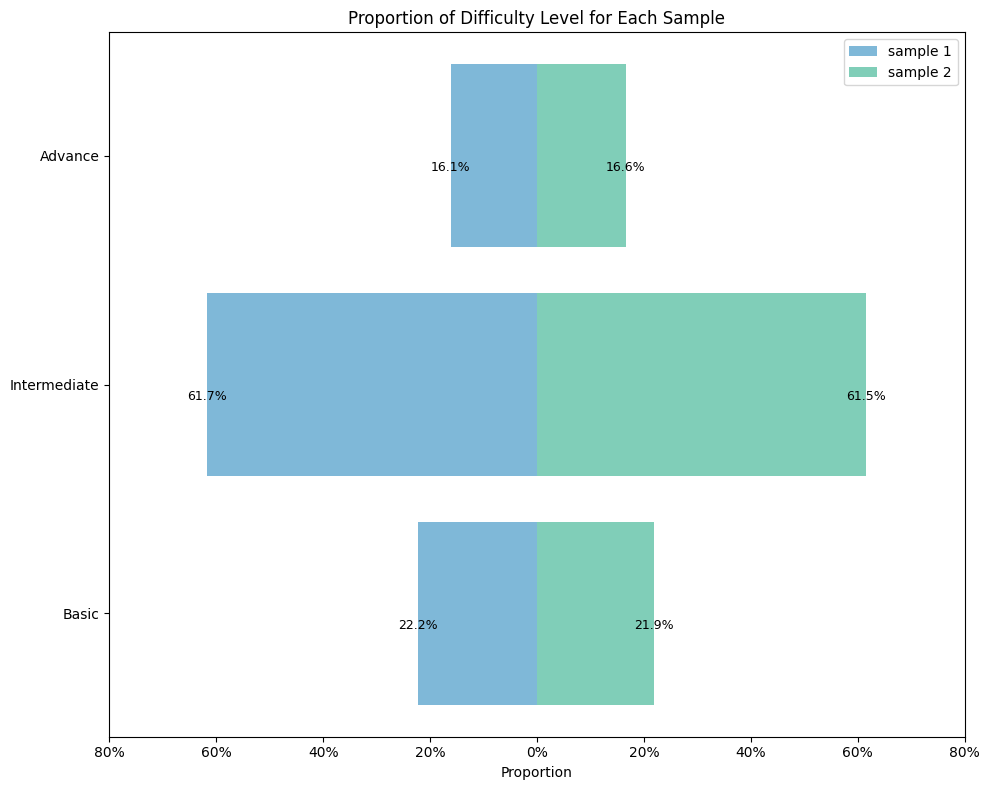

In [15]:
import matplotlib.pyplot as plt
import numpy as np

palette = sns.color_palette("colorblind")
y = np.arange(len(s2_tot_prop['o_result']))

# 그래프 설정
plt.figure(figsize=(10, 8))
bar_smp1 = plt.barh(y, [-x for x in s1_tot_prop['proportion']], color=palette[0], label='sample 1', alpha=0.5)  # 음수로 표현
bar_smp2 = plt.barh(y, s2_tot_prop['proportion'], color=palette[2], label='sample 2', alpha=0.5)

# y축 레이블 (연령대)
plt.yticks(y, ['Basic', 'Intermediate', 'Advance'])
plt.xlabel('Proportion')
plt.title('Proportion of Difficulty Level for Each Sample')
plt.legend(loc='upper right')

for i in y:

    percent_smp1 = s1_tot_prop.loc[s1_tot_prop['o_result'] == str(i), 'proportion'].values[0]
    percent_smp2 = s2_tot_prop.loc[s2_tot_prop['o_result'] == str(i), 'proportion'].values[0]

    # 남자 바 오른쪽 끝 (음수 방향 → 왼쪽)
    plt.text([-x for x in s1_tot_prop['proportion']][i], y[i] - 0.08, f"{percent_smp1:.1f}%", ha='center', va='bottom', color='black', fontsize=9)

    # 여자 바 오른쪽 끝 (양수 방향 → 오른쪽)
    plt.text(s2_tot_prop['proportion'][i], y[i] - 0.08, f"{percent_smp2:.1f}%", ha='center', va='bottom', color='black', fontsize=9)


# x축의 눈금 표시를 절대값으로 (음수 제거)
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{abs(int(x)):,}%" for x in xticks])
plt.tight_layout()
plt.savefig(f"{fig_path}Data_2.png", dpi=300, bbox_inches='tight')
plt.show()
